# Introduction to the extended version of DiCE (Diverse Counterfactual Explanations)

[Mothilal et al. (2020)](https://dl.acm.org/doi/10.1145/3351095.3372850) introduce their method of generating counterfactual explanations considering _feasibility_, and _diversity_. [Guidotti and Ruggieri (2021)](https://link.springer.com/chapter/10.1007/978-3-030-88942-5_28), claim counterfactual explanations to be robust they should be similar for similar instances when they explain. In this study, in a search to improve the quality and reliability of the counterfactual explanations _robustness_ is found to be helpful and it also introduced in the optimization function.

DiCE-Extended is built upon the [DiCE (Diverse Counterfactual Explanations)](https://github.com/interpretml/DiCE) [(Mothilal et al. 2020)](https://dl.acm.org/doi/10.1145/3351095.3372850) framework by introducing a robustness term in the optimization function.

## Manipulated Optimization Function

The core enhancement in DiCE-Extended is the manipulated optimization function, designed to balance proximity, diversity, and feasibility of counterfactuals. The function is formulated as:

<a id="equation-1"></a>
\begin{equation}
\tag{1}
C(x) = \underset{c_1, ..., c_k}{\text{arg min}}
\frac{1}{2} \sum_{i=1}^{k} yloss(f(c_i), y) +
\frac{\lambda_1}{k} \sum_{i=1}^{k} dist(c_i, x) -
\lambda_2 \cdot dpp\_diversity(c_1, ..., c_k) -
\frac{\lambda_3}{k} \sum_{i=1}^{k} robustness(c_i, c_i')
\end{equation}

- **Proximity Loss**: The first term that averages the distance between generated counterfactuals and the original input ensure the counterfactuals to be as close as possible to the original input.
- **Diversity Loss**: Diversity of the counterfactual explanations is aquired by determinental point process of which loss is represented by the second term and it ensures that _k_ number of counterfactual explanations are generated.
- **Robustness Loss**: [Guidotti (2024)](https://link.springer.com/article/10.1007/s10618-022-00831-6) defines robustness as necessity of similar instances being explained by similar counterfactual explanations such that if $b(x_1)=b(x_2)=y$ then an explainer $f$ should generate counterfactuals $c_1$ and $c_2$ that are similar and can explain $x_1$ and $x_2$. The robustness term that is based on [Dice-Sørensen Coefficient](https://en.wikipedia.org/wiki/Dice-S%C3%B8rensen_coefficient), is adopted from [Bonasera and Carrizosa (2024)](
https://doi.org/10.48550/arXiv.2407.00843).

\begin{equation}
\tag{2}
Robustness(c_i, c_i') = \frac{2 * \lvert c_i \cap c_i' \rvert}{\lvert c_i \rvert + \lvert c_i' \rvert}
\end{equation}


By adjusting the weights $\lambda_1$, $\lambda_2$, $\lambda_3$ counterfactual explanations can be customised by specific needs.

### IMPORTANT NOTE

Some of the calculations in this notebook may yield slightly different results across runs. This variability is due to the stochastic nature of optimization processes, random initializations, and other computation dependent factors. Please keep this in mind when interpreting the results. For reproducibility, consider setting random seeds where applicable.

In [21]:
import sys
dice_path = "/Users/volk/Documents/bau24-25/thesis/repos/DiCE-X"
sys.path.insert(0, dice_path)

In [151]:
import dice_ml_x
from dice_ml_x.utils import helpers, neuralnetworks
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import itertools
from tqdm import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
from dice_ml_x.benchmarking import Benchmarking
datasets = ["compas-recidivism", "adult-income", "lending-club", "german-credit"]
backends = ["sklearn", "PYT", "TF2"]
methods =['gaussian']
benchmarking = Benchmarking(datasets=datasets,
                            backends=backends,
                            perturbation_methods=methods)
benchmarking.load_and_train(batch_size=16)

""" At the end of the load and train process a dictionary containing the training and counterfactual
generation history is saved following object can be found in the results object:
"""

Benchmarking:   0%|          | 0/12 [00:00<?, ?it/s]

the dataset is : compas-recidivism, the backend is : sklearn, the method is gaussian


Benchmarking:   8%|▊         | 1/12 [00:10<01:54, 10.40s/it, dataset=compas-recidivism, backend=sklearn, method=gaussian]

the dataset is : compas-recidivism, the backend is : PYT, the method is gaussian


/Users/volk/Documents/bau24-25/thesis/repos/DiCE-X/dice_ml_x/explainer_interfaces/dice_pytorch.py:407: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BucketizationUtils.h:34.)
  binned_indices = torch.bucketize(col_vals, edges, right=False) - 1
Benchmarking:  17%|█▋        | 2/12 [00:14<01:06,  6.62s/it, dataset=compas-recidivism, backend=PYT, method=gaussian]    

Diverse Counterfactuals found! total time taken: 00 min 02 sec
the dataset is : compas-recidivism, the backend is : TF2, the method is gaussian


Benchmarking:  25%|██▌       | 3/12 [00:46<02:45, 18.37s/it, dataset=compas-recidivism, backend=TF2, method=gaussian]

Diverse Counterfactuals found! total time taken: 00 min 30 sec
the dataset is : adult-income, the backend is : sklearn, the method is gaussian


Benchmarking:  33%|███▎      | 4/12 [01:39<04:14, 31.84s/it, dataset=adult-income, backend=sklearn, method=gaussian] 

the dataset is : adult-income, the backend is : PYT, the method is gaussian


Benchmarking:  42%|████▏     | 5/12 [01:53<02:57, 25.42s/it, dataset=adult-income, backend=PYT, method=gaussian]    

Diverse Counterfactuals found! total time taken: 00 min 06 sec
the dataset is : adult-income, the backend is : TF2, the method is gaussian


Benchmarking:  50%|█████     | 6/12 [02:45<03:27, 34.57s/it, dataset=adult-income, backend=TF2, method=gaussian]

Diverse Counterfactuals found! total time taken: 00 min 43 sec
the dataset is : lending-club, the backend is : sklearn, the method is gaussian


Benchmarking:  58%|█████▊    | 7/12 [04:40<05:04, 60.88s/it, dataset=lending-club, backend=sklearn, method=gaussian]

the dataset is : lending-club, the backend is : PYT, the method is gaussian


Benchmarking:  67%|██████▋   | 8/12 [05:06<03:19, 49.76s/it, dataset=lending-club, backend=PYT, method=gaussian]    

Diverse Counterfactuals found! total time taken: 00 min 16 sec
the dataset is : lending-club, the backend is : TF2, the method is gaussian


Benchmarking:  75%|███████▌  | 9/12 [08:37<05:00, 100.23s/it, dataset=lending-club, backend=TF2, method=gaussian]

Diverse Counterfactuals found! total time taken: 03 min 20 sec
the dataset is : german-credit, the backend is : sklearn, the method is gaussian


Benchmarking:  83%|████████▎ | 10/12 [12:15<04:33, 136.52s/it, dataset=german-credit, backend=sklearn, method=gaussian]

the dataset is : german-credit, the backend is : PYT, the method is gaussian


Benchmarking:  92%|█████████▏| 11/12 [12:26<01:38, 98.16s/it, dataset=german-credit, backend=PYT, method=gaussian]     

Diverse Counterfactuals found! total time taken: 00 min 08 sec


the dataset is : german-credit, the backend is : TF2, the method is gaussian


Benchmarking: 100%|██████████| 12/12 [13:28<00:00, 67.40s/it, dataset=german-credit, backend=TF2, method=gaussian]

Diverse Counterfactuals found! total time taken: 00 min 59 sec


' At the end of the load and train process a dictionary containing the training and counterfactual\ngeneration history is saved following object can be found in the results object:\n'

In [11]:
with open('benchmarking_final_results.pkl', 'wb') as res_file:
    pickle.dump(benchmarking.results, res_file)

In [4]:
with open('benchmarking_final_results.pkl', 'rb') as res_file:
    benchmarking_results = pickle.load(res_file)

### Explainers' Loss Chart

During the counterfactual generation process we keep track of each losses computed for the optimization process. The chart below shows that the counterfactuals are optimized depending on various type of losses i.e., class loss, proximity loss, diversity loss, and robustness loss. The algorithm although reached a plateau around 50th iteration since the stopping criteria which is loss difference isn't met the loop keeps the calculations. The other stopping criteria is maximum number of iterations which is set to 5000. The chart is plotted without considering the weights for losses. 

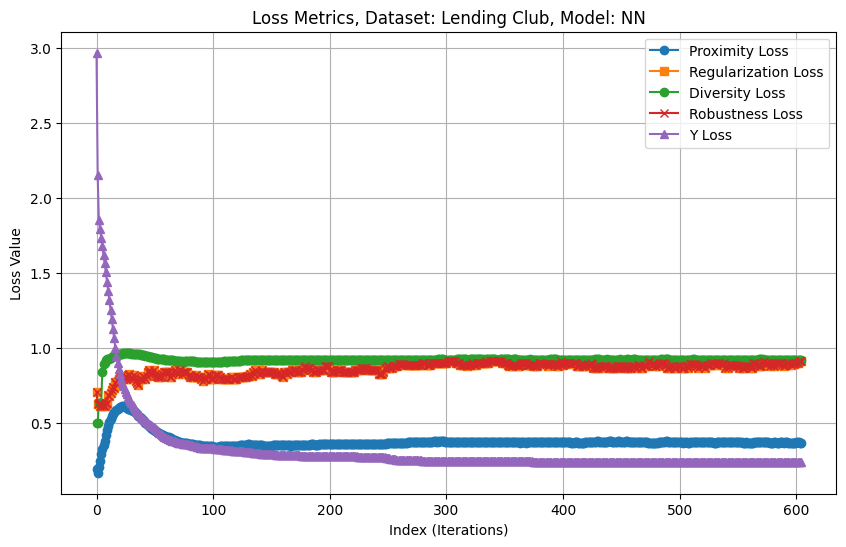

In [140]:
import matplotlib.pyplot as plt

def plot_loss_metrics(loss_metrics, proximity_weight=1.0, diversity_weight=1.0,
                      robustness_weight=1.0):
    proximity_loss = loss_metrics["proximity_loss"] if proximity_weight == 1.0 else [loss * proximity_weight for loss in loss_metrics["proximity_loss"]]
    sparsity_loss = loss_metrics["regularization_loss"]
    robustness_loss = loss_metrics["robustness_loss"] if robustness_weight == 1.0 else [loss * robustness_weight for loss in loss_metrics['robustness_loss']]
    diversity_loss = loss_metrics["diversity_loss"] if diversity_weight == 1.0 else [loss * diversity_weight for loss in loss_metrics['diversity_loss']]
    yloss = loss_metrics["y_loss"]
    
    plt.figure(figsize=(10, 6))

    plt.plot(proximity_loss, label="Proximity Loss", marker='o')
    plt.plot(sparsity_loss, label="Regularization Loss", marker='s')
    plt.plot(diversity_loss, label="Diversity Loss", marker="o")
    plt.plot(robustness_loss, label="Robustness Loss", marker='x')
    plt.plot(yloss, label="Y Loss", marker='^')
    #plt.plot(total_loss, label="Total Loss", marker='v')

    plt.title("Loss Metrics, Dataset: Lending Club, Model: NN")
    plt.xlabel("Index (Iterations)")
    plt.ylabel("Loss Value")
    plt.legend()
    plt.grid()

    plt.show()

plot_loss_metrics(exp.loss_history)

The chart below is plotted by considering the loss weights which are 0.5, 1.0, 0.4 for proximity loss, diversity loss, and robustness loss respectively.

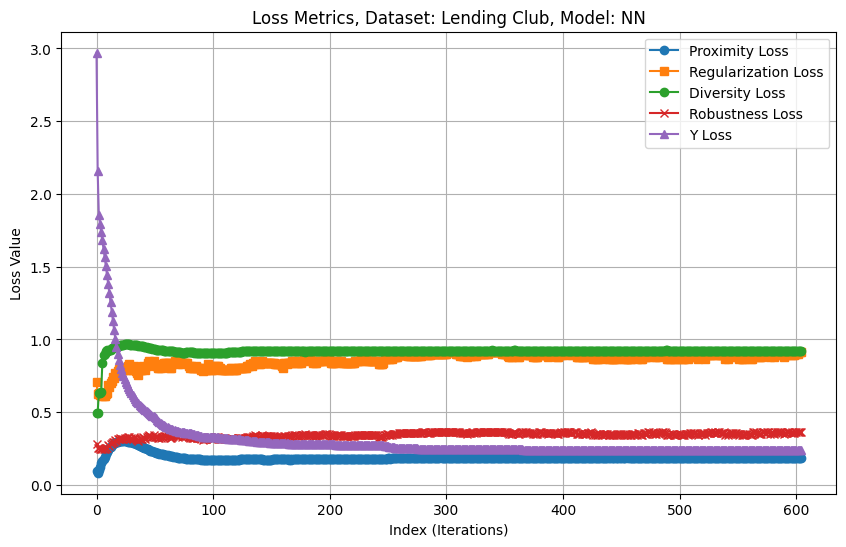

In [141]:
plot_loss_metrics(exp.loss_history, proximity_weight=0.5,
                  diversity_weight=1.0, robustness_weight=0.4)

## Models' accuracies on all four datasets

We trained two types of model with three different frameworks. Firstly, a tree model is created by using sci-kit learn framework's RandomForestClassifier with the datasets with default settings. The other two models are created with PyTorch and TensorFlow frameworks. These neural networks have two layers and the architecture is same as present in the DiCE repository as follows:

\begin{equation}
\tag{3}
Linear(number\_of\_features, 20) → ReLU → Linear(20, 1) → Sigmoid
\end{equation}

While training the neural networks following hyperparameters are used:
- Learning rate: 0.001
- Number of epochs: 10
- Train dataset size: Dataset size * 80%
- Test dataset size: Dataset size * 20%
- Number of batches for training dataset: 16
- Number of batches for test dataset: 4
- Optimizer: Adam

In [18]:
# Accuracy table for each dataset

from IPython.display import display
import pandas as pd

accuracy_data = {
    dataset: {
        model: {
            'accuracy':  f"{round(details['accuracy'] * 100, 2)}%" 
        }
        for model, details in models.items()
    }
    for dataset, models in benchmarking_results.items()
}

rows = []

for dataset, models in accuracy_data.items():
    for model_name, model_info in models.items():
        row = {
            'Dataset': dataset,
            'Model': 'Random Forest Classifier' if model_name == 'sklearn' else f'Neural Network ({model_name})',
            'Accuracy': model_info.get('accuracy'),
        }
        rows.append(row)


accuracy_df = pd.DataFrame(rows)
display(accuracy_df)
accuracy_df['Dataset'] = accuracy_df["Dataset"].mask(accuracy_df["Dataset"].duplicated(), "")
markdown_table = accuracy_df.to_markdown(index=False)
print(markdown_table)

,Dataset,Model,Accuracy
0,compas-recidivism,Random Forest Classifier,57.14%
1,compas-recidivism,Neural Network (PYT),65.79%
2,compas-recidivism,Neural Network (TF2),65.49%
3,adult-income,Random Forest Classifier,81.84%
4,adult-income,Neural Network (PYT),83.36%
5,adult-income,Neural Network (TF2),83.43%
6,lending-club,Random Forest Classifier,82.39%
7,lending-club,Neural Network (PYT),82.92%
8,lending-club,Neural Network (TF2),82.94%
9,german-credit,Random Forest Classifier,75.5%


| Dataset           | Model                    | Accuracy   |
|:------------------|:-------------------------|:-----------|
| compas-recidivism | Random Forest Classifier | 57.14%     |
|                   | Neural Network (PYT)     | 65.79%     |
|                   | Neural Network (TF2)     | 65.49%     |
| adult-income      | Random Forest Classifier | 81.84%     |
|                   | Neural Network (PYT)     | 83.36%     |
|                   | Neural Network (TF2)     | 83.43%     |
| lending-club      | Random Forest Classifier | 82.39%     |
|                   | Neural Network (PYT)     | 82.92%     |
|                   | Neural Network (TF2)     | 82.94%     |
| german-credit     | Random Forest Classifier | 75.5%      |
|                   | Neural Network (PYT)     | 77.5%      |
|                   | Neural Network (TF2)     | 78.5%      |


| Dataset           | Model                    | Accuracy   |
|:------------------|:-------------------------|:-----------|
| compas-recidivism | Random Forest Classifier | 57.14%     |
|                   | Neural Network (PYT)     | 65.79%     |
|                   | Neural Network (TF2)     | 65.49%     |
| adult-income      | Random Forest Classifier | 81.84%     |
|                   | Neural Network (PYT)     | 83.36%     |
|                   | Neural Network (TF2)     | 83.43%     |
| lending-club      | Random Forest Classifier | 82.39%     |
|                   | Neural Network (PYT)     | 82.92%     |
|                   | Neural Network (TF2)     | 82.94%     |
| german-credit     | Random Forest Classifier | 75.5%      |
|                   | Neural Network (PYT)     | 77.5%      |
|                   | Neural Network (TF2)     | 78.5%      |


As it can be seen from the table the models performed satisfying both with [Adult Income Dataset](https://archive.ics.uci.edu/dataset/2/adult) and the [Lending Club Dataset](https://www.lendingclub.com/). While models perform moderately on [German Credit Risk Dataset](https://archive.ics.uci.edu/static/public/144/statlog+german+credit+data.zip), they perform poorly on [Compas Recidivism Dataset](https://api.openml.org/data/download/22111929/dataset).

## Explainers' counterfactual generation time with different datasets

Three types of explainers are generated for counterfactual generation that are genetic, PyTorch, and TensorFlow. Counterfactuals generated by genetic algorithm are generated with a genetic algorithm creates mutations with the best counterfactuals depending on the loss value. The gradient methods use Adam optimizer with a learning rate of $0.05$ and parameterize the counterfactuals to optimize counterfactuals. During the counterfactual generation process 5 counterfactuals has been created. The table below shows time spent for counterfactual generation for each model and dataset. PYT represents a neural network model created with PyTorch and TF2 represents a neural network model created with TensorFlow framework.

| Dataset           | Model          |   Time (ms) |
|:------------------|:---------------|------------:|
| compas-recidivism | Genetic        |       10.22 |
| compas-recidivism | Gradient (PYT) |        2.69 |
| compas-recidivism | Gradient (TF2) |       30.95 |
| adult-income      | Genetic        |       49.08 |
| adult-income      | Gradient (PYT) |        7.14 |
| adult-income      | Gradient (TF2) |       43.72 |
| lending-club      | Genetic        |      110.42 |
| lending-club      | Gradient (PYT) |       17.32 |
| lending-club      | Gradient (TF2) |      200.41 |
| german-credit     | Genetic        |      217.62 |
| german-credit     | Gradient (PYT) |       10.89 |
| german-credit     | Gradient (TF2) |       61.37 |

In [19]:
# Counterfactual generation time table
time_spent_data = {
    dataset: {
        model: {
            'time': round(details['time']['gaussian'], 2)
        }
        for model, details in models.items()
    }
    for dataset, models in benchmarking_results.items()
}

rows = []

for dataset, models in time_spent_data.items():
    for model_name, model_info in models.items():
        row = {
            'Dataset': dataset,
            'Model': 'Genetic' if model_name == 'sklearn' else f'Gradient ({model_name})',
            'Time (ms)': model_info.get('time'),
        }
        rows.append(row)

time_df = pd.DataFrame(rows)
display(time_df)
markdown_table = time_df.to_markdown(index=False)
print(markdown_table)

,Dataset,Model,Time (ms)
0,compas-recidivism,Genetic,10.22
1,compas-recidivism,Gradient (PYT),2.69
2,compas-recidivism,Gradient (TF2),30.95
3,adult-income,Genetic,49.08
4,adult-income,Gradient (PYT),7.14
5,adult-income,Gradient (TF2),43.72
6,lending-club,Genetic,110.42
7,lending-club,Gradient (PYT),17.32
8,lending-club,Gradient (TF2),200.41
9,german-credit,Genetic,217.62


| Dataset           | Model          |   Time (ms) |
|:------------------|:---------------|------------:|
| compas-recidivism | Genetic        |       10.22 |
| compas-recidivism | Gradient (PYT) |        2.69 |
| compas-recidivism | Gradient (TF2) |       30.95 |
| adult-income      | Genetic        |       49.08 |
| adult-income      | Gradient (PYT) |        7.14 |
| adult-income      | Gradient (TF2) |       43.72 |
| lending-club      | Genetic        |      110.42 |
| lending-club      | Gradient (PYT) |       17.32 |
| lending-club      | Gradient (TF2) |      200.41 |
| german-credit     | Genetic        |      217.62 |
| german-credit     | Gradient (PYT) |       10.89 |
| german-credit     | Gradient (TF2) |       61.37 |


## Metrics and Sensitivity Analysis for Dice Extended


### 1. Robustness Metrics

#### Dice-Sørensen Coefficient

To evaluate robustness, the Dice-Sørensen coefficient measures the similarity between counterfactuals c1 and
c2 generated for similar input instances x1 and x2:

\begin{equation}
\tag{4}
Robustness(c_1, c_2) = \frac{2 * \lvert c_1 \cap c_2 \rvert}{\lvert c_1 \rvert + \lvert c_2 \rvert}
\end{equation}

where:
- $ c_1 $ and $ c_2 $ are binary vectors,
- $ \lvert c_1 \cap c_2 \rvert $: The number of shared (overlapping) features between c1 and c2,
- $ \lvert c_1 \rvert $ and $ \lvert c_2 \rvert $: The total number of features in each counterfactual.

#### Input Perturbation and Stability

Stability under input perturbation measures the solution variance when slight perturbations are introduced
to the input instance. The procedure includes the following steps:

1) **Apply Gaussian Noise:** Perturb the input $x$ by adding Gaussian noise $\delta$ to create perturbed inputs
$x'$:

\begin{equation}
\tag{5}
x' = x + \delta, \quad \delta \sim \mathcal{N}(0, \sigma^2)
\end{equation}

where $\sigma$ is the standard deviation of the noise (e.g., $\sigma = 0.01$).

2) **Generate Counterfactuals:** Generate counterfactual explanations $c_i$ for the original input $x$ and $c_i'$ for the perturbed input $x'$.

3) **Measure Stability:** Compare counterfactuals using a distance metric, such as the Euclidean distance:

\begin{equation}
\tag{6}
Stability = \frac{1}{n} \sum_{i=1}^{n} dist(c_i, c_i')
\end{equation}

where:

\begin{equation}
\tag{7}
dist(c_i, c_i') = \sqrt{\sum_{j=1}^{d} (c_{ij} - c_{ij}')^2}
\end{equation}

$n$ is the total number of input instances, $c_i$ is the counterfactual for the original input, and $c_i'$ is the counterfactual for the perturbed input.

In the section below we will do the required computation to calculate the stability of the counterfactuals. Firstly we pick an instance from the dataset which is $x$ and generate counterfactuals to it. Subsequently, we perturb $x$ and obtain $x'$ and generate counterfactuals also for it.

In [35]:
lending_df = helpers.load_lending_club_dataset()
target = lending_df['loan_status']
train_dataset, test_dataset, y_train, y_test =train_test_split(lending_df, target,
                                                               test_size=0.2, random_state=42,
                                                               stratify=target)
dummy_state_dict = torch.load(benchmarking_results['lending-club']['PYT']['model_path'])
dummy_state_dict = {f'model.{key}': value for key, value in dummy_state_dict.items()}
in_features = dummy_state_dict['model.0.weight'].shape[1]
model_path = benchmarking_results['lending-club']['PYT']['model_path']
model = neuralnetworks.PYTModel(in_features)
model.load_state_dict(dummy_state_dict)

cont_feats = lending_df.select_dtypes(include=[np.number]).columns.difference(['loan_status']).tolist()
d = dice_ml_x.Data(dataframe=train_dataset, continuous_features=cont_feats, outcome_name='loan_status')
gaussian_kwargs = {}
m = dice_ml_x.Model(model=model.model, backend='PYT', func='ohe-min-max')
exp = dice_ml_x.DiceX(d, m, method="gradient")
# generate counterfactuals

x_train, x_test = train_dataset.drop(columns=['loan_status']), test_dataset.drop(columns=['loan_status'])

x = x_test[1:2]

dice_exp = exp.generate_counterfactuals(x, total_CFs=10, desired_class="opposite",
                                        perturbation_method="gaussian", **gaussian_kwargs)
# highlight only the changes
dice_exp.visualize_as_dataframe(show_only_changes=False)
C = dice_exp.to_dataframe()

  0%|          | 0/1 [00:00<?, ?it/s]/Users/volk/Documents/bau24-25/thesis/repos/DiCE-X/dice_ml_x/explainer_interfaces/dice_pytorch.py:407: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BucketizationUtils.h:34.)
  binned_indices = torch.bucketize(col_vals, edges, right=False) - 1
100%|██████████| 1/1 [01:54<00:00, 114.89s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec
Query instance (original outcome : 0.7739999890327454)


,employment_years,num_open_credit_acc,annual_income,loan_grade,credit_history,purpose,home,addr_state,loan_status
0,5,12,175000.0,F,16.5,purchase,MORTGAGE,PA,0.774



Diverse Counterfactual set (new outcome: 0.0)


,employment_years,num_open_credit_acc,annual_income,loan_grade,credit_history,purpose,home,addr_state,loan_status
0,10,44,232320.6,A,3.0,small_business,MORTGAGE,VA,0
1,0,20,187159.0,G,22.7,purchase,MORTGAGE,ID,0
2,0,12,4080.0,G,12.5,purchase,MORTGAGE,ID,0
3,0,30,373745.1,F,55.6,purchase,MORTGAGE,VT,0
4,0,44,4080.0,G,31.0,purchase,MORTGAGE,VT,0
5,0,44,140301.5,F,3.0,purchase,MORTGAGE,ID,0
6,0,41,178061.3,F,57.1,purchase,MORTGAGE,VT,0
7,0,44,328889.2,G,16.5,purchase,MORTGAGE,ID,0
8,0,38,64723.7,D,16.5,purchase,MORTGAGE,VT,0
9,3,44,552552.4,A,16.5,purchase,MORTGAGE,VT,0


In [ ]:
x_ohe = d.get_ohe_min_max_normalized_data(x)
cat_cols = d.get_encoded_categorical_feature_indexes()
cat_cols = [col for group in cat_cols for col in group]
continuous_feature_indexes = list(set(list(range(len(d.get_ohe_min_max_normalized_data(x).columns)))) - set(cat_cols))
categorical_feature_indexes = d.get_encoded_categorical_feature_indexes()


def do_perturbation(x: pd.DataFrame):
        x_tensor = torch.tensor(x.values, dtype=torch.float32)
    
        #cfs_perturbed = torch.nn.Parameter(x_tensor.clone(), requires_grad=True)

        if continuous_feature_indexes:
            
            continuous_slice = x_tensor[:, continuous_feature_indexes]
            noise = continuous_slice * 0.1
            noise_mask = torch.zeros_like(x_tensor)
            noise_mask[:, continuous_feature_indexes] = noise
            x_tensor = x_tensor + noise_mask

        if categorical_feature_indexes:
            for cat_cols in categorical_feature_indexes:
                cat_slice = x_tensor[:, cat_cols]
                sample_size = cat_slice.shape[0]
                num_cats = cat_slice.shape[1]

                rand_idx = torch.randint(low=0, high=num_cats, size=(sample_size, ))

                cat_slice_perturbed = torch.nn.functional.one_hot(rand_idx, num_classes=num_cats).float()

                cat_mask = torch.zeros_like(x_tensor)
                cat_mask[:, cat_cols] = cat_slice_perturbed
                x_perturbed = x_tensor + cat_mask
        return x_perturbed

def generate_perturbations(x_ohe: pd.DataFrame, model: any,
                           max_iter=100, tol=1e-3, gamma=1e-2):
        x_ohe_tensor = torch.tensor(x_ohe.values, dtype=torch.float32, requires_grad=True)
        x_perturbed = do_perturbation(x_ohe)
        perturbation_optimizer = torch.optim.Adam([x_perturbed], lr=1e-3)

        prev_loss = np.inf
        for _ in range(max_iter):
            with torch.no_grad():
                model.model.eval()
                pred_i = model.model(x_ohe_tensor)
                pred_i_prime = model.model(x_perturbed)
            class_loss = torch.mean((pred_i - pred_i_prime) ** 2)
            distance = torch.norm(x_perturbed - x_ohe_tensor, p=2)
            loss = class_loss + gamma * distance


            perturbation_optimizer.zero_grad()
            loss.backward()

            perturbation_optimizer.step()
            if abs(loss.item() - prev_loss) < tol:
                break
            prev_loss = loss.item()
        return x_perturbed.detach()

x_prime_ohe_tensor = generate_perturbations(x_ohe, model)
x_prime_decoded = d.get_decoded_data(x_prime_ohe_tensor.numpy())
x_prime = d.get_inverse_ohe_min_max_normalized_data(x_prime_decoded)
x_prime['employment_years'] = x_prime['employment_years'].astype(int)
x_prime['num_open_credit_acc'] = x_prime['num_open_credit_acc'].astype(int)
print("Original instance")
display(x)
print("Perturbed instance")
display(x_prime)


Original instance


,employment_years,num_open_credit_acc,annual_income,loan_grade,credit_history,purpose,home,addr_state
24355,5,12,175000.0,F,16.5,purchase,MORTGAGE,PA


Perturbed instance


,employment_years,num_open_credit_acc,annual_income,loan_grade,credit_history,purpose,home,addr_state
0,6,14,209184.0,F,19.2,purchase,MORTGAGE,DC


In [109]:
exp = dice_ml_x.DiceX(d, m, method="gradient")
dice_exp_prime = exp.generate_counterfactuals(x_prime, total_CFs=10, desired_class="opposite",
                                        perturbation_method="gaussian", **gaussian_kwargs)
C_prime = dice_exp_prime.to_dataframe()
na_cols = C_prime.columns[C_prime.isna().any().tolist()].tolist()
C_prime[na_cols] = C_prime[na_cols].fillna(x_prime[na_cols].iloc[0])
C_prime['loan_status'] = (C_prime['loan_status'] >= 0.5).astype(int)
display(C_prime)

100%|██████████| 1/1 [00:10<00:00, 10.87s/it]

Diverse Counterfactuals found! total time taken: 00 min 10 sec


,employment_years,num_open_credit_acc,annual_income,loan_grade,credit_history,purpose,home,addr_state,loan_status
0,10,44,224523.0,F,3.0,purchase,MORTGAGE,DC,0
1,0,30,200241.2,F,57.1,purchase,MORTGAGE,DC,0
2,0,40,4080.0,F,57.1,purchase,MORTGAGE,DC,0
3,3,44,150000.1,F,19.4,purchase,MORTGAGE,DC,0
4,0,15,197364.4,F,31.1,purchase,MORTGAGE,DC,0
5,0,44,4080.0,F,17.7,purchase,MORTGAGE,DC,0
6,0,44,317526.5,F,28.3,purchase,MORTGAGE,DC,0
7,10,44,465049.4,F,3.0,purchase,MORTGAGE,DC,0
8,0,40,440197.2,F,57.1,purchase,MORTGAGE,DC,0
9,2,44,639564.6,F,19.2,purchase,MORTGAGE,DC,0


In [145]:
C_ohe_tensor = torch.tensor(d.get_ohe_min_max_normalized_data(C).values, dtype=torch.float32)
C_prime_ohe_tensor = torch.tensor(d.get_ohe_min_max_normalized_data(C_prime).values, dtype=torch.float32)

def compute_stability(C_set_1: torch.Tensor, C_set_2: torch.Tensor, p: int=2) -> float:
    return torch.mean(torch.cdist(C_set_1, C_set_2, p=2)).item()

stability = compute_stability(C_ohe_tensor, C_prime_ohe_tensor)
stability

2.065671443939209

#### Result for Stability

We computed the stability metric by converting the $C$ and $C'$ into a normalized vector that are of shape (10, 70) which means there are 10 samples with 70 features. The result of the calculation of stability under input perturbation is $~2.07$. When we consider the maximum distance between two vectors of shape (10, 70) maximum distance should equal to $~8.37$

\begin{equation}
\tag{8}
\sqrt{70 \times (1 - 0)} = 8.37
\end{equation}

### 2. Counterfactual Quality Measures

#### Fidelity

Fidelity measures how often generated counterfactuals successfully change the model’s prediction:

\begin{equation}
\tag{9}
Fidelity = \frac{\sum_{i=1}^{n} \mathbf{1}(f(c_i) = y_{desired})}{n}
\end{equation}

where:

- $f$: Prediction model,
- $c_i$: Counterfactual instance,
- $y_{desired}$: Target output class,
- $n$: Total number of counterfactuals.

Since all generated counterfactuals belong to the desired class $fidelity$ of the counterfactuals is $100\%$

#### Proximity

Proximity measures the average distance between counterfactuals $c_i$ and the original inputs $x_i$:

\begin{equation}
\tag{10}
Proximity = \frac{1}{n} \sum_{i=1}^{n} dist(x_i, c_i)
\end{equation}

The Manhattan distance can be used for simplicity:

\begin{equation}
\tag{11}
dist(x_i, c_i) = \sum_{j=1}^{d} \lvert x_{ij} - c_{ij} \rvert
\end{equation}


In [146]:
x_ohe_tensor = torch.tensor(d.get_ohe_min_max_normalized_data(train_dataset[1:2]).values, dtype=torch.float32)

def compute_proximity(original_instance: torch.Tensor, C: torch.Tensor) -> float:
    return torch.mean(torch.cdist(original_instance, C, p=1)).item()

proximity = compute_proximity(x_ohe_tensor, C_ohe_tensor)
proximity

7.653975009918213

#### Result for Proximity

We computed the proximity of $x$ and $C$ we converted them into normalized and one hot encoded tensors of shape (10, 70). The resulting total proximity between the original instance and generated counterfactuals is $7.65$ which is highly acceptable when we consider the maximum Manhattan distance between these two tensors which is $70$.


#### Diversity

Diversity measures how dissimilar the counterfactuals $c_1, c_2, c_3,\ldots,c_k$ are among themselves:

\begin{equation}
\tag{12}
Diversity = \frac{1}{k(k-1)}\sum_{i_1}^{k}\sum_{j \neq i}^{} dist(c_i, c_j)
\end{equation}

where $k$ is the number of counterfactuals.

In [147]:
def compute_diversity(C_ohe: torch.Tensor):
    k = C_ohe.shape[0]
    pairwise_dist = torch.cdist(C_ohe, C_ohe, p=2)
    diversity = (torch.sum(pairwise_dist) - torch.sum(torch.diagonal(pairwise_dist))) / (k * (k - 1))
    return diversity.item()

diversity = compute_diversity(C_ohe_tensor)
diversity

1.8660491704940796

#### Result for Diversity

For the counterfactuals tensor we work with minimum diversity value is $0$ that indicates all counterfactuals are identical. For the condition that all counterfactuals are distinct that makes the diversity value maximum which is $~4.19$. The diversity value we calculated with the counterfactuals is $1.87$ which seems that counterfactuals have a moderate spread in the features space.

### 3. Sensitivity Analysis

#### Objective Function with Weights

The modified loss function in DiCE-Extended is defined as in the [equation 1](#equation-1) where:

- $yloss(f(c_i), y)$: Prediction loss for counterfactual instance $c_i$ relative to the desired outcome $y$,
- $dist(c_i, x)$: Distance metric (e.g., Euclidean or Manhattan) between the counterfactual c_i and the original input $x$,
- $dpp\_diversity(c_1,\ldots,c_k)$: Diversity loss term based on Determinantal Point Process (DPP),
- $Robustness(c_i,c_i')$: Robustness loss measuring similarity of counterfactuals under perturbations.

  The weights $\lambda_1, \lambda_2, \lambda_3$ control the balance between proximity, diversity, and robustness, respectively.

#### Sensitivity Analysis

To perform sensitivity analysis:

1) Vary the weights $\lambda_1, \lambda_2, \lambda_3$ systematically while ensuring:

\begin{equation}
\tag{13}
\lambda_1 + \lambda_2 + \lambda_3 = 1 \text{ (for normalization)}.
\end{equation}

2) Track the changes in the following metrics:

\begin{equation}
\tag{14}
P(\lambda_1, \lambda_2, \lambda_3) = Proximity,
\end{equation}

\begin{equation}
\tag{15}
D(\lambda_1, \lambda_2, \lambda_3) = Diversity,
\end{equation}

\begin{equation}
\tag{16}
R(\lambda_1, \lambda_2, \lambda_3) = Robustness,
\end{equation}

3) Measure the relationship between these metrics and the weights.

In [164]:
d.get_inverse_ohe_min_max_normalized_data(x_ohe)

,employment_years,num_open_credit_acc,annual_income,loan_grade,credit_history,purpose,home,addr_state
0,5.0,12.0,175000.0,F,16.5,purchase,MORTGAGE,PA


In [167]:
weight_grid = [(l1, l2, 1 - l1 - l2)
               for l1, l2 in itertools.product(np.linspace(0, 1, 11), repeat=2)
               if l1 + l2 <= 1]

results = []
exp = dice_ml_x.DiceX(d, m, method="gradient")
for proximity_weight, diversity_weight, robustness_weight in tqdm(weight_grid, desc="Generating Counterfactuals"):
    cf_explanations = exp.generate_counterfactuals(x, total_CFs=10, desired_class="opposite",
                                     perturbation_method="gaussian", proximity_weight=proximity_weight,
                                     diversity_weight=diversity_weight, robustness_weight=robustness_weight,
                                     **gaussian_kwargs)
    C = cf_explanations.to_dataframe()
    C_ohe = d.get_ohe_min_max_normalized_data(C)
    C_ohe_tensor = torch.tensor(C_ohe.values, dtype=torch.float32)
    proximity = compute_proximity(x_ohe_tensor, C_ohe_tensor)
    diversity = compute_diversity(C_ohe_tensor)
    C_targetless = C.drop(columns=['loan_status'])
    C_ohe_targetless = d.get_ohe_min_max_normalized_data(C_targetless)
    C_ohe_prime_tensor = generate_perturbations(C_ohe_targetless, model)
    robustness = torch.mean(torch.norm(torch.tensor(C_ohe_targetless.values, dtype=torch.float32) - C_ohe_prime_tensor, dim=1)).item()
    results.append((proximity_weight, diversity_weight, robustness_weight, proximity, diversity, robustness))

results = np.array(results)

Generating Counterfactuals:   2%|▏         | 1/66 [01:56<2:05:46, 116.09s/it]

Diverse Counterfactuals found! total time taken: 00 min 09 sec


Generating Counterfactuals:   3%|▎         | 2/66 [03:51<2:03:33, 115.83s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:   5%|▍         | 3/66 [04:40<1:29:27, 85.20s/it] 

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:   6%|▌         | 4/66 [04:50<57:17, 55.45s/it]  

Diverse Counterfactuals found! total time taken: 00 min 09 sec


Generating Counterfactuals:   8%|▊         | 5/66 [05:00<39:41, 39.04s/it]

Diverse Counterfactuals found! total time taken: 00 min 09 sec


Generating Counterfactuals:   9%|▉         | 6/66 [05:12<29:46, 29.78s/it]

Diverse Counterfactuals found! total time taken: 00 min 11 sec


Generating Counterfactuals:  11%|█         | 7/66 [07:09<57:32, 58.52s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  12%|█▏        | 8/66 [07:18<41:21, 42.79s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  14%|█▎        | 9/66 [09:21<1:04:20, 67.72s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  15%|█▌        | 10/66 [09:32<46:44, 50.08s/it] 

Diverse Counterfactuals found! total time taken: 00 min 10 sec


Generating Counterfactuals:  17%|█▋        | 11/66 [11:27<1:04:22, 70.23s/it]

Diverse Counterfactuals found! total time taken: 00 min 10 sec


Generating Counterfactuals:  18%|█▊        | 12/66 [13:21<1:15:06, 83.45s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  20%|█▉        | 13/66 [14:08<1:03:48, 72.24s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  21%|██        | 14/66 [14:17<46:09, 53.26s/it]  

Diverse Counterfactuals found! total time taken: 00 min 09 sec


Generating Counterfactuals:  23%|██▎       | 15/66 [14:26<34:02, 40.05s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  24%|██▍       | 16/66 [14:38<26:08, 31.36s/it]

Diverse Counterfactuals found! total time taken: 00 min 10 sec


Generating Counterfactuals:  26%|██▌       | 17/66 [16:31<45:52, 56.17s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  27%|██▋       | 18/66 [16:40<33:30, 41.88s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  29%|██▉       | 19/66 [18:33<49:36, 63.32s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  30%|███       | 20/66 [18:43<36:18, 47.36s/it]

Diverse Counterfactuals found! total time taken: 00 min 09 sec


Generating Counterfactuals:  32%|███▏      | 21/66 [20:38<50:39, 67.54s/it]

Diverse Counterfactuals found! total time taken: 00 min 09 sec


Generating Counterfactuals:  33%|███▎      | 22/66 [21:24<44:50, 61.14s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  35%|███▍      | 23/66 [21:34<32:39, 45.57s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  36%|███▋      | 24/66 [21:43<24:17, 34.70s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  38%|███▊      | 25/66 [21:54<18:53, 27.64s/it]

Diverse Counterfactuals found! total time taken: 00 min 10 sec


Generating Counterfactuals:  39%|███▉      | 26/66 [23:48<35:36, 53.40s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  41%|████      | 27/66 [23:56<25:59, 39.98s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  42%|████▏     | 28/66 [25:49<39:13, 61.93s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  44%|████▍     | 29/66 [26:00<28:40, 46.50s/it]

Diverse Counterfactuals found! total time taken: 00 min 09 sec


Generating Counterfactuals:  45%|████▌     | 30/66 [27:54<40:00, 66.68s/it]

Diverse Counterfactuals found! total time taken: 00 min 09 sec


Generating Counterfactuals:  47%|████▋     | 31/66 [28:03<28:51, 49.47s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  48%|████▊     | 32/66 [28:12<21:12, 37.44s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  50%|█████     | 33/66 [28:24<16:15, 29.56s/it]

Diverse Counterfactuals found! total time taken: 00 min 10 sec


Generating Counterfactuals:  52%|█████▏    | 34/66 [30:16<29:06, 54.57s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  53%|█████▎    | 35/66 [30:25<21:03, 40.77s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  55%|█████▍    | 36/66 [32:19<31:18, 62.62s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  56%|█████▌    | 37/66 [32:29<22:42, 46.99s/it]

Diverse Counterfactuals found! total time taken: 00 min 10 sec


Generating Counterfactuals:  58%|█████▊    | 38/66 [34:22<31:06, 66.66s/it]

Diverse Counterfactuals found! total time taken: 00 min 09 sec


Generating Counterfactuals:  59%|█████▉    | 39/66 [34:29<22:00, 48.89s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals:  61%|██████    | 40/66 [34:38<15:57, 36.85s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  62%|██████▏   | 41/66 [36:07<21:53, 52.52s/it]

Diverse Counterfactuals found! total time taken: 00 min 06 sec


Generating Counterfactuals:  64%|██████▎   | 42/66 [36:14<15:31, 38.83s/it]

Diverse Counterfactuals found! total time taken: 00 min 06 sec


Generating Counterfactuals:  65%|██████▌   | 43/66 [37:43<20:40, 53.92s/it]

Diverse Counterfactuals found! total time taken: 00 min 06 sec


Generating Counterfactuals:  67%|██████▋   | 44/66 [37:51<14:44, 40.20s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals:  68%|██████▊   | 45/66 [39:22<19:23, 55.38s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals:  70%|██████▉   | 46/66 [39:31<13:49, 41.49s/it]

Diverse Counterfactuals found! total time taken: 00 min 08 sec


Generating Counterfactuals:  71%|███████   | 47/66 [41:04<18:00, 56.87s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals:  73%|███████▎  | 48/66 [41:11<12:34, 41.91s/it]

Diverse Counterfactuals found! total time taken: 00 min 06 sec


Generating Counterfactuals:  74%|███████▍  | 49/66 [42:40<15:54, 56.13s/it]

Diverse Counterfactuals found! total time taken: 00 min 06 sec


Generating Counterfactuals:  76%|███████▌  | 50/66 [42:48<11:07, 41.70s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals:  77%|███████▋  | 51/66 [44:18<14:04, 56.27s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals:  79%|███████▉  | 52/66 [45:48<15:29, 66.37s/it]

Diverse Counterfactuals found! total time taken: 00 min 06 sec


Generating Counterfactuals:  80%|████████  | 53/66 [45:55<10:30, 48.51s/it]

Diverse Counterfactuals found! total time taken: 00 min 06 sec


Generating Counterfactuals:  82%|████████▏ | 54/66 [47:24<12:08, 60.74s/it]

Diverse Counterfactuals found! total time taken: 00 min 06 sec


Generating Counterfactuals:  83%|████████▎ | 55/66 [47:32<08:14, 44.94s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals:  85%|████████▍ | 56/66 [49:03<09:45, 58.57s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals:  86%|████████▋ | 57/66 [49:10<06:27, 43.06s/it]

Diverse Counterfactuals found! total time taken: 00 min 06 sec


Generating Counterfactuals:  88%|████████▊ | 58/66 [50:39<07:35, 56.97s/it]

Diverse Counterfactuals found! total time taken: 00 min 06 sec


Generating Counterfactuals:  89%|████████▉ | 59/66 [50:47<04:56, 42.35s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals:  91%|█████████ | 60/66 [52:17<05:39, 56.62s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals:  92%|█████████▏| 61/66 [53:46<05:31, 66.28s/it]

Diverse Counterfactuals found! total time taken: 00 min 06 sec


Generating Counterfactuals:  94%|█████████▍| 62/66 [53:54<03:15, 48.81s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals:  95%|█████████▌| 63/66 [55:24<03:03, 61.08s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals:  97%|█████████▋| 64/66 [55:32<01:30, 45.16s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals:  98%|█████████▊| 65/66 [57:01<00:58, 58.49s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


Generating Counterfactuals: 100%|██████████| 66/66 [58:32<00:00, 53.22s/it]

Diverse Counterfactuals found! total time taken: 00 min 07 sec


In [168]:
with open('weight_sensitivity_results.pkl', 'wb') as sens_file:
    pickle.dump(results, sens_file)

In [178]:
with open('weight_sensitivity_results.pkl', 'rb') as sens_file:
    sens_res_loaded = pickle.load(sens_file)

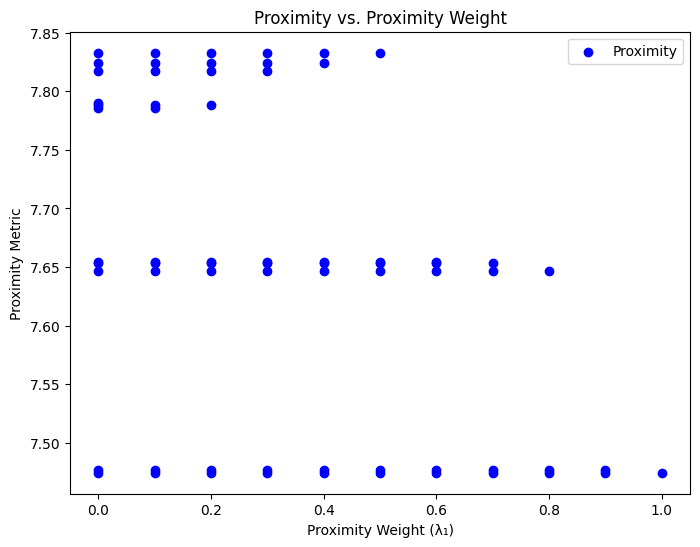

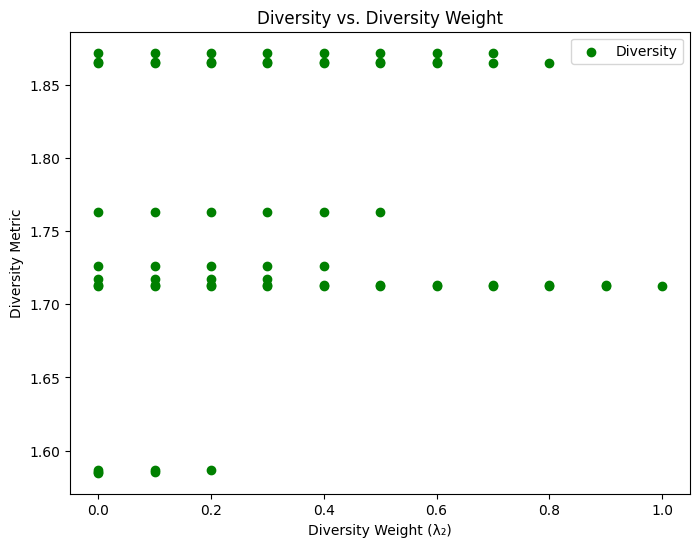

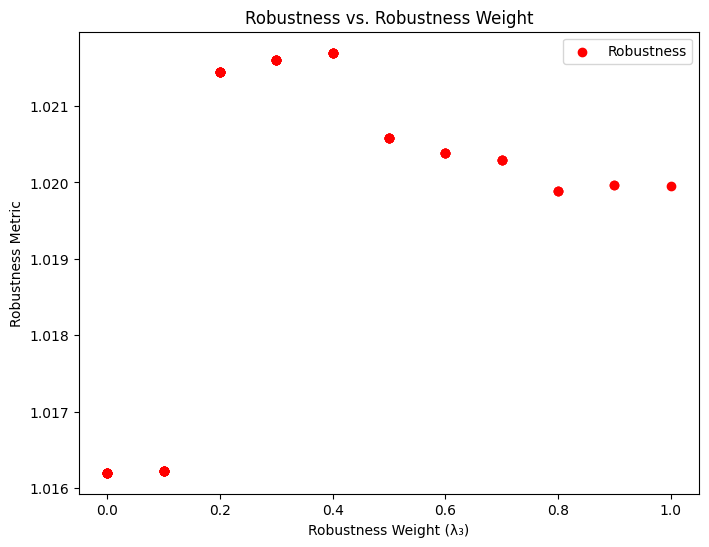

In [176]:
columns = ['proximity_weight', 'diversity_weight', 'robustness_weight', 'proximity', 'diversity', 'robustness']
results_df = pd.DataFrame(results, columns=columns)

# Plot proximity vs. proximity weight
plt.figure(figsize=(8, 6))
plt.scatter(results_df['proximity_weight'], results_df['proximity'], c='blue', label='Proximity')
plt.title('Proximity vs. Proximity Weight')
plt.xlabel('Proximity Weight (λ₁)')
plt.ylabel('Proximity Metric')
plt.legend()
plt.show()

# Plot diversity vs. diversity weight
plt.figure(figsize=(8, 6))
plt.scatter(results_df['diversity_weight'], results_df['diversity'], c='green', label='Diversity')
plt.title('Diversity vs. Diversity Weight')
plt.xlabel('Diversity Weight (λ₂)')
plt.ylabel('Diversity Metric')
plt.legend()
plt.show()

# Plot robustness vs. robustness weight
plt.figure(figsize=(8, 6))
plt.scatter(results_df['robustness_weight'], results_df['robustness'], c='red', label='Robustness')
plt.title('Robustness vs. Robustness Weight')
plt.xlabel('Robustness Weight (λ₃)')
plt.ylabel('Robustness Metric')
plt.legend()
plt.show()

As it can be seen from the charts proximity and diversity are not sensitive to changes in $\lambda_1$ and $\lambda_2$. On the other hand, robustness seems to be sensitive to changes in $\lambda_3$

In [184]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

cols_to_normalize = ['proximity', 'diversity', 'robustness']

results_normalized_df = results_df.copy().__deepcopy__()

results_normalized_df[cols_to_normalize] = scaler.fit_transform(results_normalized_df[cols_to_normalize])

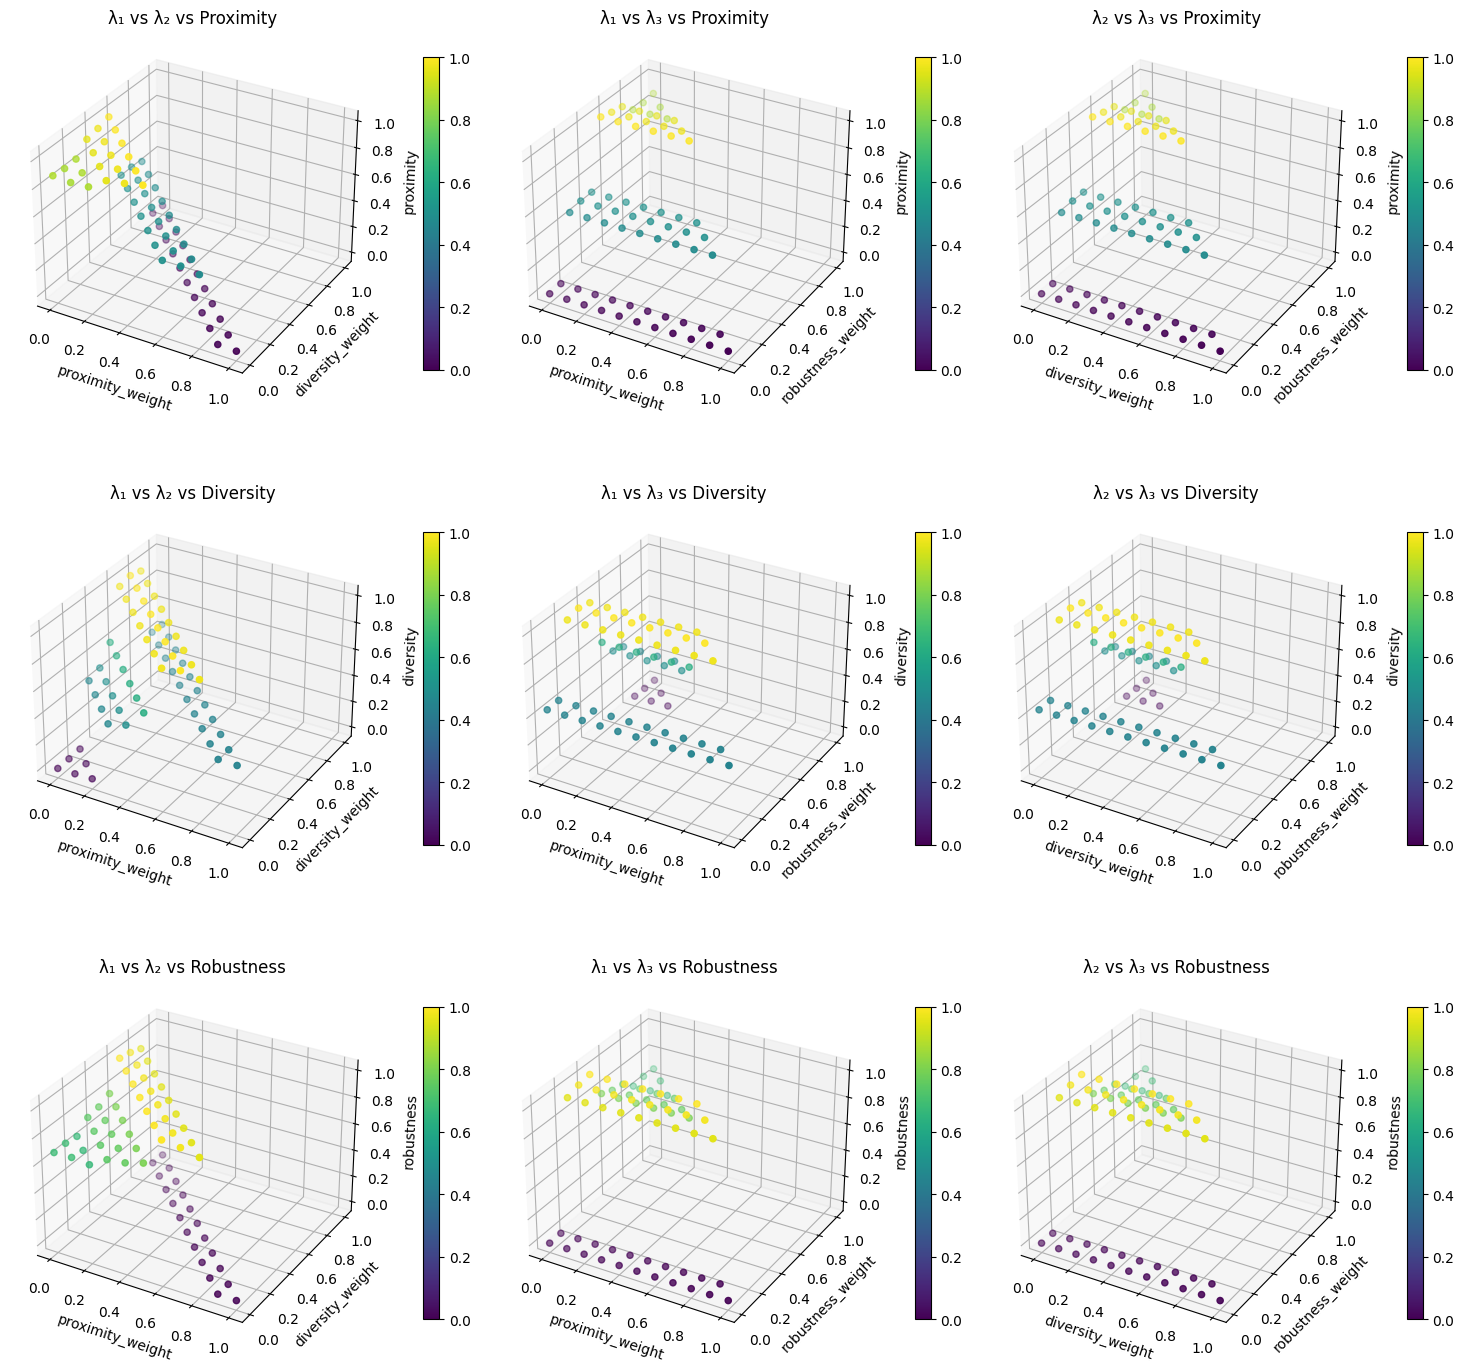

In [191]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), subplot_kw={'projection': '3d'})

combinations = [
    ('proximity_weight', 'diversity_weight', 'proximity'),
    ('proximity_weight', 'robustness_weight', 'proximity'),
    ('diversity_weight', 'robustness_weight', 'proximity'),
    ('proximity_weight', 'diversity_weight', 'diversity'),
    ('proximity_weight', 'robustness_weight', 'diversity'),
    ('diversity_weight', 'robustness_weight', 'diversity'),
    ('proximity_weight', 'diversity_weight', 'robustness'),
    ('proximity_weight', 'robustness_weight', 'robustness'),
    ('diversity_weight', 'robustness_weight', 'robustness'),
]

titles = [
    'λ₁ vs λ₂ vs Proximity',
    'λ₁ vs λ₃ vs Proximity',
    'λ₂ vs λ₃ vs Proximity',
    'λ₁ vs λ₂ vs Diversity',
    'λ₁ vs λ₃ vs Diversity',
    'λ₂ vs λ₃ vs Diversity',
    'λ₁ vs λ₂ vs Robustness',
    'λ₁ vs λ₃ vs Robustness',
    'λ₂ vs λ₃ vs Robustness',
]

for ax, (x, y, z), title in zip(axes.flatten(), combinations, titles):
    sc = ax.scatter(results_normalized_df[x], results_normalized_df[y], results_normalized_df[z],
                    c=results_normalized_df[z], cmap='viridis')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    ax.set_title(title)
    fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)

plt.tight_layout()
plt.show()